In [1]:
import pandas as pd
import numpy as np
import ccxt
import sys
import os
from typing import Dict, Any, List, Tuple

# เพิ่ม current directory เข้าไปใน Python path
sys.path.insert(0, os.getcwd())

from popquants_grid_allocator import build_grid

# ==============================
# ฟังก์ชันช่วย: ดึง min_notional / minQty จาก Binance ผ่าน ccxt
# ==============================
def fetch_ccxt_constraints(symbol: str, exchange_id: str = "binance") -> Dict[str, float]:
    """
    คืนค่า dict: {
        'min_notional': float หรือ None,
        'min_qty': float หรือ None
    }
    """
    ex = getattr(ccxt, exchange_id)({"enableRateLimit": True})
    ex.load_markets()
    m = ex.market(symbol)

    min_notional = None
    min_qty = None

    # 1) พยายามใช้ unified limits ก่อน (ถ้ามี)
    limits = m.get("limits", {})
    cost = limits.get("cost", {}) if isinstance(limits, dict) else {}
    if isinstance(cost, dict) and cost.get("min") is not None:
        try:
            min_notional = float(cost["min"])
        except Exception:
            pass

    amount = limits.get("amount", {}) if isinstance(limits, dict) else {}
    if isinstance(amount, dict) and amount.get("min") is not None:
        try:
            min_qty = float(amount["min"])
        except Exception:
            pass

    # 2) ถ้ายังไม่มี ให้ดูจาก info.filters ของ Binance
    if min_notional is None or min_qty is None:
        filters = m.get("info", {}).get("filters", []) or []
        for f in filters:
            ftype = f.get("filterType")
            if ftype in ("MIN_NOTIONAL", "NOTIONAL") and min_notional is None:
                raw = f.get("minNotional") or f.get("notional")
                if raw is not None:
                    try:
                        min_notional = float(raw)
                    except Exception:
                        pass
            if ftype == "LOT_SIZE" and min_qty is None:
                raw = f.get("minQty")
                if raw is not None:
                    try:
                        min_qty = float(raw)
                    except Exception:
                        pass

    return {
        "min_notional": float(min_notional) if min_notional is not None else None,
        "min_qty": float(min_qty) if min_qty is not None else None,
    }


# ==============================
# โหลดไฟล์ CSV ที่ได้จากสคริปต์ Monte Carlo
# ==============================
df = pd.read_csv("macro_montecarlo.csv")

# ==============================
# 1) ดึงแถวสรุป (summary row) — แถวสุดท้าย
# ==============================
summary = df.iloc[-1]   # แถวสุดท้ายเป็น summary row
spot = float(summary["spot"])
band_low = float(summary["band_low"])
band_high = float(summary["band_high"])

# ==============================
# 2) ดึงตัวอย่างราคาต่ำสุดต่อเส้นทาง (ใช้สำหรับ equal-prob)
#    เลือกเฉพาะแถวที่ path_id ไม่เป็น NaN
# ==============================
path_df = df[df["path_id"].notna()]
mc_mins_samples = path_df["min_price"].to_numpy(dtype=float)

# ==============================
# 3) คำนวณ w_min จาก ccxt (Binance) ให้เหมาะกับ SYMBOL
#    - ใช้ min_notional (เช่น ~10 USDT) เป็นฐาน
#    - กันกรณีเล็กกว่าขั้นต่ำเชิงปริมาณ: max(min_notional, spot * minQty)
#    - ตั้ง fallback ถ้าหาไม่ได้
# ==============================
SYMBOL = "JTO/USDT"
# SYMBOL = "XRP/USDT"
ccxt_info = fetch_ccxt_constraints(SYMBOL, exchange_id="binance")
min_notional = ccxt_info.get("min_notional")
min_qty = ccxt_info.get("min_qty")

# ฐานขั้นต่ำตามกติกา
w_min_ccxt = None
candidates = []
if min_notional is not None:
    candidates.append(min_notional)
if (min_qty is not None) and spot > 0:
    candidates.append(spot * min_qty)

if candidates:
    w_min_ccxt = float(max(candidates))
else:
    # Fallback ถ้าดึงไม่ได้
    w_min_ccxt = 10.0

# เพื่อความปลอดภัย: เผื่อ buffer เล็กน้อย 1% (กันกรณีราคา/ทศนิยมปัดแล้วต่ำกว่า)
w_min_ccxt = float(np.ceil(w_min_ccxt * 1.01 * 100) / 100.0)

# ตั้ง w_max ให้ไม่ต่ำกว่า w_min
w_max_cfg = 50.0
if w_max_cfg < w_min_ccxt:
    w_max_cfg = w_min_ccxt

print("[i] ข้อจำกัดจากตลาด (ccxt/Binance):")
print(f"    min_notional ≈ {min_notional if min_notional is not None else 'N/A'} USDT")
print(f"    min_qty      ≈ {min_qty if min_qty is not None else 'N/A'} {SYMBOL.split('/')[0]}")
print(f"    spot         = {spot:.6f} → spot*minQty ≈ {spot*min_qty:.4f} USDT" if min_qty is not None else f"    spot         = {spot:.6f}")
print(f"    → เลือก w_min = {w_min_ccxt:.2f} USDT  (w_max = {w_max_cfg:.2f})")

# ==============================
# 4) เรียก build_grid เพื่อสร้างแผนกริด (ใช้ w_min จาก ccxt)
# ==============================
budget = 300.0

result = build_grid(
    spot=spot,
    band_low=band_low,
    band_high=band_high,
    budget_usd=budget,
    K=30,                        # จำนวนชั้นกริด (กำหนดคงที่เป็น 20 ในตัวอย่างนี้)
    method="equal_prob",         # กระจายจุดกริดตาม quantile จากตัวอย่าง min ของ MC
    mc_mins_samples=mc_mins_samples,
    alpha=0.8,                   # กันสำรองงบไว้ 30% (ใช้ทุนคาดหวังไม่เกิน 70% ของงบ)
    w_min=w_min_ccxt,            # << ใช้ค่าขั้นต่ำต่อคำสั่งจาก ccxt
    w_max=w_max_cfg,             # << ให้ไม่ต่ำกว่า w_min
    fee_rate=0.0004,             # ค่าธรรมเนียมต่อรอบ (ประมาณ 0.04%)
    tp_pct=0.01,                 # เป้า TP ต่อคำสั่ง 1% จากราคาเข้าซื้อ
    zone_near=0.05,              # โซนใกล้ (±5% รอบ spot)
    zone_mid=0.15,               # โซนกลาง (±15% รอบ spot)
    weight_scheme="far_heavier"  # เน้นน้ำหนักชั้นที่ไกลจาก spot มากกว่า (FAR หนักสุด)
)

# ==============================
# 5) แสดงผลลัพธ์
# ==============================
print("\n=== แผนวางกริด (อ่านจาก macro_montecarlo.csv) ===")
print(f"ราคาปัจจุบัน (Spot): {result['spot']:.6f} | ช่วงคาดการณ์ (Band): {result['band_low']:.6f} → {result['band_high']:.6f}")
print("จำนวนชั้นในแต่ละโซน (Zone counts):", result["zone_counts"])
print("สรุปภาพรวม (Totals):", result["totals"])

print("\nคำสั่งซื้อ (Orders):")
print("ZONE | buy_price | usd_alloc | coin_size | tp_price | net_pct_est")
for r in result["orders"]:
    print(f"{r['zone']:>4} | {r['buy_price']:.6f} | {r['usd_alloc']:>8.2f} "
          f"| {r['coin_size']:>9.6f} | {r['tp_price']:.6f} | {r['net_pct_est']:.4%}")

# บันทึกคำสั่งลงไฟล์ CSV
pd.DataFrame(result["orders"]).to_csv("grid_plan.csv", index=False)
print("\n[i] บันทึกแผนกริดลงไฟล์: grid_plan.csv เรียบร้อยแล้ว")

[i] ข้อจำกัดจากตลาด (ccxt/Binance):
    min_notional ≈ 5.0 USDT
    min_qty      ≈ 0.1 JTO
    spot         = 1.661000 → spot*minQty ≈ 0.1661 USDT
    → เลือก w_min = 5.05 USDT  (w_max = 50.00)

=== แผนวางกริด (อ่านจาก macro_montecarlo.csv) ===
ราคาปัจจุบัน (Spot): 1.661000 | ช่วงคาดการณ์ (Band): 0.896699 → 2.927268
จำนวนชั้นในแต่ละโซน (Zone counts): {'near': 2, 'mid': 5, 'far': 23, 'Total_levels': 30}
สรุปภาพรวม (Totals): {'total_usd': 302.53, 'est_net_pct_per_fill': 0.0092}

คำสั่งซื้อ (Orders):
ZONE | buy_price | usd_alloc | coin_size | tp_price | net_pct_est
 far | 1.419519 |    31.09 | 21.901228 | 1.433714 | 0.9200%
 far | 1.447074 |    28.22 | 19.499505 | 1.461545 | 0.9200%
 far | 1.456856 |    27.18 | 18.656793 | 1.471424 | 0.9200%
 far | 1.478779 |    24.82 | 16.783359 | 1.493567 | 0.9200%
 far | 1.510156 |    21.34 | 14.128776 | 1.525257 | 0.9200%
 far | 1.526875 |    19.42 | 12.720587 | 1.542144 | 0.9200%
 far | 1.543876 |    17.43 | 11.287752 | 1.559315 | 0.9200%
 mid | 1.58

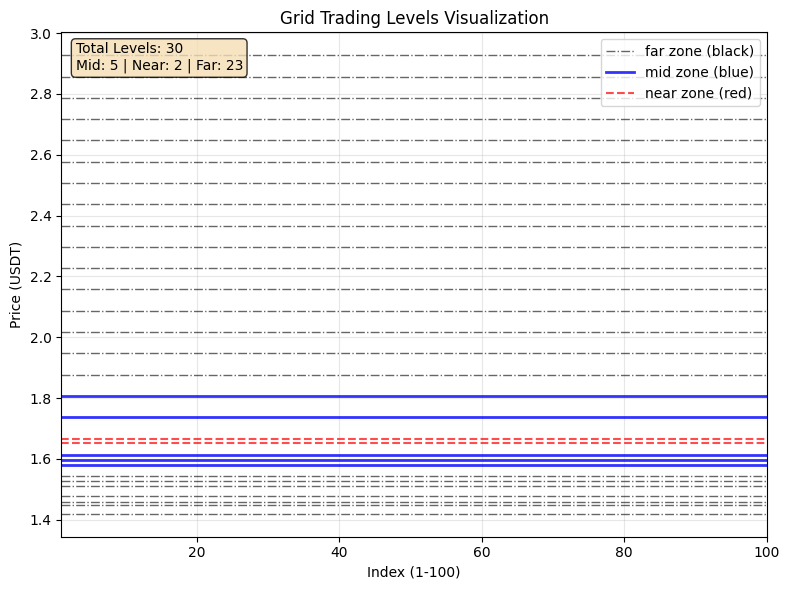


📊 Grid Levels Summary:
Total Levels: 30
Mid Zone: 5 levels
Near Zone: 2 levels
Far Zone: 23 levels
Price Range: 1.419519 - 2.927268 USDT


In [2]:
# พลอตกราฟแสดง Grid Levels
import matplotlib.pyplot as plt
import numpy as np

# อ่านข้อมูลจาก grid_plan.csv
grid_df = pd.read_csv('grid_plan.csv')

# สร้างกราฟ
plt.figure(figsize=(8, 6))

# สร้าง index 1-100
x_index = np.arange(1, 101)

# เก็บ zone ที่แสดงแล้วเพื่อไม่ให้ซ้ำใน legend
shown_zones = set()

# พลอตเส้นแนวนอนสำหรับแต่ละ grid level
for i, (idx, row) in enumerate(grid_df.iterrows()):
    price = row['buy_price']
    zone = row['zone']
    
    # กำหนดสีตาม zone
    if zone == 'mid':
        color = 'blue'
        alpha = 0.8
        linewidth = 2
        linestyle = '-'
    elif zone == 'near':
        color = 'red'
        alpha = 0.7
        linewidth = 1.5
        linestyle = '--'
    else:  # far
        color = 'black'
        alpha = 0.6
        linewidth = 1
        linestyle = '-.'
    
    # พลอตเส้นแนวนอน
    if zone not in shown_zones:
        plt.axhline(y=price, color=color, alpha=alpha, linewidth=linewidth, 
                    linestyle=linestyle, label=f'{zone} zone ({color})')
        shown_zones.add(zone)
    else:
        plt.axhline(y=price, color=color, alpha=alpha, linewidth=linewidth, 
                    linestyle=linestyle)

# ตั้งค่าแกน
plt.xlabel('Index (1-100)')
plt.ylabel('Price (USDT)')
plt.title('Grid Trading Levels Visualization')
plt.grid(True, alpha=0.3)

# จำกัดแกน X เป็น 1-100
plt.xlim(1, 100)

# จำกัดแกน Y ให้ครอบคลุมราคาทั้งหมด
min_price = grid_df['buy_price'].min()
max_price = grid_df['buy_price'].max()
price_range = max_price - min_price
plt.ylim(min_price - price_range*0.05, max_price + price_range*0.05)

# แสดง legend
plt.legend(loc='upper right')

# แสดงข้อมูลสถิติ
total_levels = len(grid_df)
mid_levels = len(grid_df[grid_df['zone'] == 'mid'])
near_levels = len(grid_df[grid_df['zone'] == 'near'])
far_levels = len(grid_df[grid_df['zone'] == 'far'])

plt.text(0.02, 0.98, f'Total Levels: {total_levels}\nMid: {mid_levels} | Near: {near_levels} | Far: {far_levels}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"\n📊 Grid Levels Summary:")
print(f"Total Levels: {total_levels}")
print(f"Mid Zone: {mid_levels} levels")
print(f"Near Zone: {near_levels} levels") 
print(f"Far Zone: {far_levels} levels")
print(f"Price Range: {min_price:.6f} - {max_price:.6f} USDT")
